## prepocessing data

As in PS2, we use polymorphic SNPs on chromosome 16 for analyzing population structure. We first use bcftools to convert the VCF files to matrix format, where each column represents a sample, and each row represents the genotype (0,1,2). We also filter SNPs with MAF >=1%, and SNPs with more than 2 alleles.

We use three files: chr16.genotypes.tab, chr16.samples.txt, chr16.reference_labels.csv

In [1]:
%%bash

bcftools query -e'AF<0.01' -e'AF>0.99' -f "[%GT\t]\n" /datasets/cs284s-sp20-public/ps2/ps2_pca.genotypes.vcf.gz | \
  sed 's/0|0/0/g' | sed 's/0|1/1/g' | sed 's/1|0/1/g' | sed 's/1|1/2/g' | \
  grep -v "|" \
  > ~/final_project/chr16.genotypes.tab

In [3]:
%%bash

bcftools query -l /datasets/cs284s-sp20-public/ps2/ps2_pca.genotypes.vcf.gz > ~/final_project/chr16.samples.txt
cp /datasets/cs284s-sp20-public/ps2/ps2_reference_labels.csv ~/final_project/chr16.reference_labels.csv

In [1]:
# load the genotype matrix
import numpy as np
import os

gene_matrix = np.loadtxt(os.environ["HOME"]+"/final_project/chr16.genotypes.tab")
gene_matrix.shape

(28622, 2504)

In [71]:
# Load population labels
sample_to_pop = {}
with open(os.environ["HOME"]+"/final_project/chr16.reference_labels.csv", "r") as f:
    for line in f:
        sample, pop = line.strip().split(",")
        sample_to_pop[sample] = pop

pop_to_color = {"ACB": "blue", "ASW": "blue",  
                "CDX": "green", "CHB": "green", "CHS": "green", "JPT": "green", "KHV": "green", 
                "CEU": "yellow", "FIN": "yellow", "GBR": "yellow", "IBS": "yellow", "TSI": "yellow",
                "CLM": "purple", "MXL": "purple", "PEL": "purple", "PUR": "purple", 
                "GIH": "orange", "PJL": "orange", "BEB": "orange", "STU": "orange", "ITU": "orange",
                "LWK": "red","MSL": "red", "YRI": "red", "GWD": "red", "ESN": "red",
               }

# Load samples list and get colors
samples = [item.strip() for item in open(os.environ["HOME"]+"/final_project/chr16.samples.txt").readlines()]
colors = []
super_pop = []
for sample in samples:
    pop = sample_to_pop.get(sample)
    color = pop_to_color[pop]
    colors.append(color)
    if pop in ['ACB','ASW']:
        super_pop.append(0)
    elif pop in ['CDX','CHB','CHS','JPT','KHV']:
        super_pop.append(1)
    elif pop in ['CEU','FIN','GBR','IBS','TSI']:
        super_pop.append(2)
    elif pop in ['CLM','MXL','PEL','PUR']:
        super_pop.append(3)
    elif pop in ['GIH','PJL','BEB','STU','ITU']:
        super_pop.append(4)
    else:
        super_pop.append(5)
super_pop = np.array(super_pop)

## (1) PCA 

In [129]:
# run once
from sklearn.decomposition import PCA

start = time.time()
pca = PCA(n_components=5)
pca_component = pca.fit_transform(gene_matrix.T)
end = time.time()
print(end-start)
np.savetxt(os.environ["HOME"]+"/final_project/pca/pca.projection.txt",pca_component)

1.2035927772521973


### 1.1 PCA for all samples

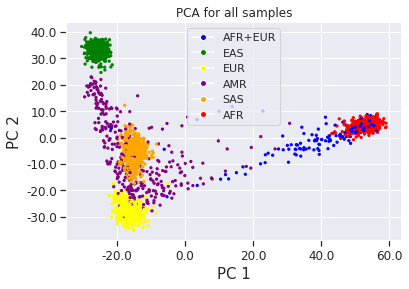

In [142]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
pca_component = np.loadtxt(os.environ["HOME"]+"/final_project/pca/pca.projection.txt")
pc1 = pca_component[:,0]
pc2 = pca_component[:,1]

legend_elements = [Line2D([0], [0], marker='o', color='w',label='AFR+EUR',markerfacecolor='blue', markersize=6),
                   Line2D([0], [0], marker='o', color='w',label='EAS',markerfacecolor='green', markersize=6),
                   Line2D([0], [0], marker='o', color='w',label='EUR',markerfacecolor='yellow', markersize=6),
                   Line2D([0], [0], marker='o', color='w',label='AMR',markerfacecolor='purple', markersize=6),
                   Line2D([0], [0], marker='o', color='w',label='SAS',markerfacecolor='orange', markersize=6),
                   Line2D([0], [0], marker='o', color='w',label='AFR',markerfacecolor='red', markersize=6),
                   ]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc1, pc2, color=colors, s=5)
ax.set_xlabel("PC 1", size=15)
ax.set_ylabel("PC 2", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.legend(handles=legend_elements)
plt.title("PCA for all samples")
plt.savefig("super_pca.png",dpi=300, bbox_inches='tight')
plt.show()

### 1.2 PCA for East Asian Samples

In [128]:
from sklearn.decomposition import PCA
eas_pops = []
eas_index = []
i = 0
for sample in samples:
    pop = sample_to_pop.get(sample)
    if pop in ['CHB','JPT','CHS','CDX','KHV']:
        eas_pops.append(pop)
        eas_index.append(i)
    i += 1
eas_pops = np.array(eas_pops)

start = time.time()
pca = PCA(n_components=5)
pca_component = pca.fit_transform(gene_matrix.T[eas_index,:])
end = time.time()
print(end-start)
np.savetxt(os.environ["HOME"]+"/final_project/pca/eas_pca.projection.txt",pca_component)

0.26601624488830566


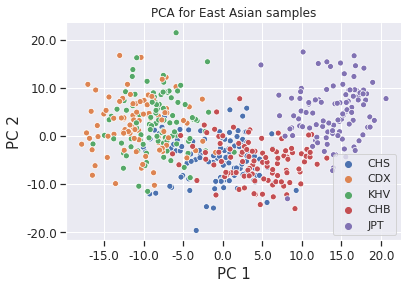

In [143]:
import seaborn as sns; sns.set()
pca_component = np.loadtxt(os.environ["HOME"]+"/final_project/pca/eas_pca.projection.txt")
pc1 = pca_component[:,0]
pc2 = pca_component[:,1]
ax = sns.scatterplot(x=pc1, y=pc2, hue=eas_pops)
ax.set_xlabel("PC 1", size=15)
ax.set_ylabel("PC 2", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
plt.title("PCA for East Asian samples")
plt.savefig("eas_pca.png",dpi=300, bbox_inches='tight')
plt.show()

### 1.3 PCA for European Samples

In [126]:
eur_pops = []
eur_index = []
i = 0
for sample in samples:
    pop = sample_to_pop.get(sample)
    if pop in ['CEU','TSI','FIN','GBR','IBS']:
        eur_pops.append(pop)
        eur_index.append(i)
    i += 1
eur_pops = np.array(eur_pops)

start = time.time()
pca = PCA(n_components=5)
pca_component = pca.fit_transform(gene_matrix.T[eur_index,:])
end = time.time()
print(end-start)
np.savetxt(os.environ["HOME"]+"/final_project/pca/eur_pca.projection.txt",pca_component)

0.2643294334411621


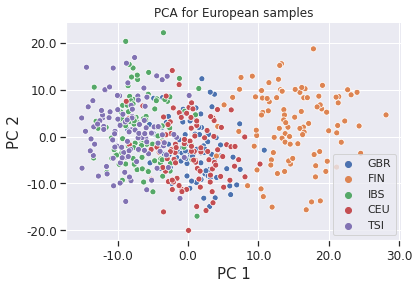

In [144]:
pca_component = np.loadtxt(os.environ["HOME"]+"/final_project/pca/eur_pca.projection.txt")
pc1 = pca_component[:,0]
pc2 = pca_component[:,1]
ax = sns.scatterplot(x=pc1, y=pc2, hue=eur_pops)
ax.set_xlabel("PC 1", size=15)
ax.set_ylabel("PC 2", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
plt.title("PCA for European samples")
plt.savefig("eur_pca.png",dpi=300, bbox_inches='tight')
plt.show()

## (2) tSNE

### 2.1 tSNE for all samples

In [26]:
from sklearn.manifold import TSNE
import time

start = time.time()
pca_component = PCA(n_components=50).fit_transform(gene_matrix.T)
tsne_component = TSNE(n_components=2).fit_transform(pca_component)

end = time.time()
print(end - start)
np.savetxt(os.environ["HOME"]+"/final_project/tsne/tsne.projection.txt",tsne_component)

4.42238974571228


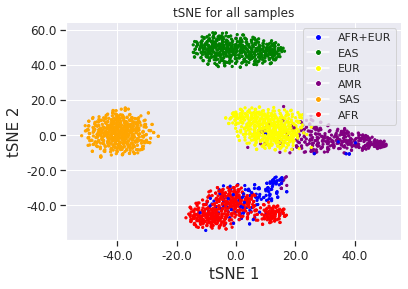

In [145]:
tsne_component = np.loadtxt(os.environ["HOME"]+"/final_project/tsne/tsne.projection.txt")
fig = plt.figure()
ax = fig.add_subplot(111)
tsne1 = tsne_component[:,0]
tsne2 = tsne_component[:,1]

ax.scatter(tsne1, tsne2, color=colors, s=5)
ax.set_xlabel("tSNE 1", size=15)
ax.set_ylabel("tSNE 2", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.legend(handles=legend_elements)
plt.title("tSNE for all samples")
plt.savefig("super_tsne.png",dpi=300, bbox_inches='tight')
plt.show()

### 2.2 tSNE for East Asian samples

In [28]:
start = time.time()
pca_component = PCA(n_components=50).fit_transform(gene_matrix.T[eas_index,:])
tsne_component = TSNE(n_components=2,perplexity=50).fit_transform(pca_component)

end = time.time()
print(end - start)
np.savetxt(os.environ["HOME"]+"/final_project/tsne/eas_tsne_p50.projection.txt",tsne_component)

1.0868330001831055


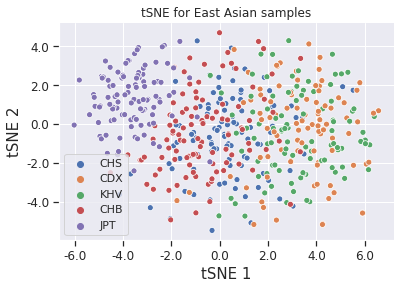

In [146]:
tsne_component = np.loadtxt(os.environ["HOME"]+"/final_project/tsne/eas_tsne_p50.projection.txt")
tsne1 = tsne_component[:,0]
tsne2 = tsne_component[:,1]
ax = sns.scatterplot(x=tsne1, y=tsne2, hue=eas_pops)
ax.set_xlabel("tSNE 1", size=15)
ax.set_ylabel("tSNE 2", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
plt.title("tSNE for East Asian samples")
plt.savefig("eas_tsne.png",dpi=300, bbox_inches='tight')
plt.show()

### 2.3 tSNE for European samples

In [130]:
start = time.time()
pca_component = PCA(n_components=50).fit_transform(gene_matrix.T[eur_index,:])
tsne_component = TSNE(n_components=2,perplexity=50).fit_transform(pca_component)

end = time.time()
print(end - start)
np.savetxt(os.environ["HOME"]+"/final_project/tsne/eur_tsne_p50.projection.txt",tsne_component)

1.0687034130096436


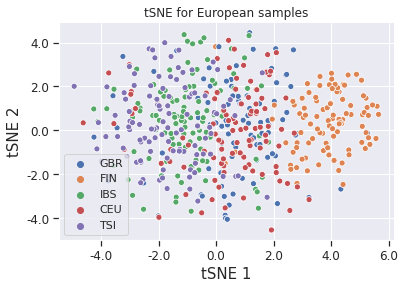

In [147]:
tsne_component = np.loadtxt(os.environ["HOME"]+"/final_project/tsne/eur_tsne_p50.projection.txt")
tsne1 = tsne_component[:,0]
tsne2 = tsne_component[:,1]
ax = sns.scatterplot(x=tsne1, y=tsne2, hue=eur_pops)
ax.set_xlabel("tSNE 1", size=15)
ax.set_ylabel("tSNE 2", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
plt.title("tSNE for European samples")
plt.savefig("eur_tsne.png",dpi=300, bbox_inches='tight')
plt.show()

## (3) UMAP

### 3.1 UMAP for all samples

In [124]:
import umap
import numba.targets

reducer = umap.UMAP()
start = time.time()
pca_component = PCA(n_components=50).fit_transform(gene_matrix.T)
umap_component = reducer.fit_transform(pca_component)
end = time.time()
print(end - start)
np.savetxt(os.environ["HOME"]+"/final_project/umap/umap.projection.txt",umap_component)

5.995267629623413


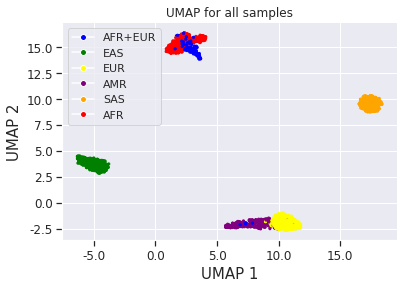

In [148]:
fig = plt.figure()
ax = fig.add_subplot(111)
umap_component = np.loadtxt(os.environ["HOME"]+"/final_project/umap/umap.projection.txt")
u1 = umap_component[:,0]
u2 = umap_component[:,1]

ax.scatter(u1, u2, color=colors, s=5)
ax.set_xlabel("UMAP 1", size=15)
ax.set_ylabel("UMAP 2", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
ax.legend(handles=legend_elements)
plt.title("UMAP for all samples")
plt.savefig("super_umap.png",dpi=300, bbox_inches='tight')
plt.show()

### 3.2 UMAP for East Asian samples

In [43]:
start = time.time()

reducer = umap.UMAP(n_neighbors=100)
%time umap_component = reducer.fit_transform(gene_matrix.T[eas_index,:])
np.savetxt(os.environ["HOME"]+"/final_project/umap/eas_umap_n100.projection.txt",umap_component)

end = time.time()
print(end - start)

CPU times: user 5.64 s, sys: 214 ms, total: 5.85 s
Wall time: 2.78 s
2.7847068309783936


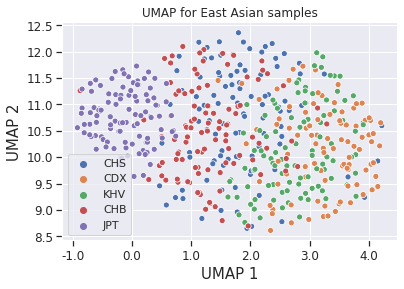

In [149]:
umap_component = np.loadtxt(os.environ["HOME"]+"/final_project/umap/eas_umap_n50.projection.txt")
u1 = umap_component[:,0]
u2 = umap_component[:,1]
ax = sns.scatterplot(x=u1, y=u2, hue=eas_pops)
ax.set_xlabel("UMAP 1", size=15)
ax.set_ylabel("UMAP 2", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
plt.title("UMAP for East Asian samples")
plt.savefig("eas_umap.png",dpi=300, bbox_inches='tight')
plt.show()

### 3.3 UMAP for European samples

In [46]:
start = time.time()

reducer = umap.UMAP(n_neighbors=50)
%time umap_component = reducer.fit_transform(gene_matrix.T[eur_index,:])
np.savetxt(os.environ["HOME"]+"/final_project/umap/eur_umap_n50.projection.txt",umap_component)

end = time.time()
print(end - start)

CPU times: user 5.11 s, sys: 193 ms, total: 5.3 s
Wall time: 2.67 s
2.669520854949951


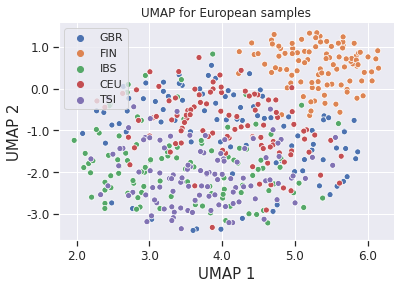

In [150]:
umap_component = np.loadtxt(os.environ["HOME"]+"/final_project/umap/eur_umap_n50.projection.txt")
u1 = umap_component[:,0]
u2 = umap_component[:,1]
ax = sns.scatterplot(x=u1, y=u2, hue=eur_pops)
ax.set_xlabel("UMAP 1", size=15)
ax.set_ylabel("UMAP 2", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
plt.title("UMAP for European samples")
plt.savefig("eur_umap.png",dpi=300, bbox_inches='tight')
plt.show()

## (4) Quantative comparisons

### 4.1 All samples

In [72]:
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.metrics import accuracy_score

all_pca_component = np.loadtxt(os.environ["HOME"]+"/final_project/pca/pca.projection.txt")
all_tsne_component = np.loadtxt(os.environ["HOME"]+"/final_project/tsne/tsne.projection.txt")
all_umap_component = np.loadtxt(os.environ["HOME"]+"/final_project/umap/umap.projection.txt")

kmeans_pca = KMeans(n_clusters=6, random_state=0)
clusters_pca = kmeans_pca.fit_predict(all_pca_component[:,[0,1]])
kmeans_tsne = KMeans(n_clusters=6, random_state=0)
clusters_tsne = kmeans_tsne.fit_predict(all_tsne_component[:,[0,1]])
kmeans_umap = KMeans(n_clusters=6, random_state=0)
clusters_umap = kmeans_umap.fit_predict(all_umap_component[:,[0,1]])

In [76]:
def CalcAccuracy(clusters,target,num_clusters):
    labels = np.zeros_like(clusters)
    for i in range(num_clusters):
        mask = (clusters == i)
        labels[mask] = mode(target[mask])[0]
    acc = accuracy_score(target, labels)
    return acc

In [77]:
print("Acc PCA: ",CalcAccuracy(clusters_pca,super_pop,6))
print("Acc tSNE: ", CalcAccuracy(clusters_tsne,super_pop,6))
print("Acc UMAP: ", CalcAccuracy(clusters_umap,super_pop,6))

Acc PCA:  0.8526357827476039
Acc tSNE:  0.9097444089456869
Acc UMAP:  0.8997603833865815


### 4.2 East Asian samples

In [79]:
eas_pca_component = np.loadtxt(os.environ["HOME"]+"/final_project/pca/eas_pca.projection.txt")
eas_tsne_component = np.loadtxt(os.environ["HOME"]+"/final_project/tsne/eas_tsne_p50.projection.txt")
eas_umap_component = np.loadtxt(os.environ["HOME"]+"/final_project/umap/eas_umap_n50.projection.txt")

kmeans_pca = KMeans(n_clusters=5, random_state=0)
clusters_pca = kmeans_pca.fit_predict(eas_pca_component[:,[0,1]])
kmeans_tsne = KMeans(n_clusters=5, random_state=0)
clusters_tsne = kmeans_tsne.fit_predict(eas_tsne_component[:,[0,1]])
kmeans_umap = KMeans(n_clusters=5, random_state=0)
clusters_umap = kmeans_umap.fit_predict(eas_umap_component[:,[0,1]])

In [121]:
def CalcAccuracy_EAS(clusters,target,num_clusters):
    labels = np.empty(clusters.shape, dtype=object)
    for i in range(num_clusters):
        mask = (clusters == i)
        labels[mask] = most_frequent(target[mask].tolist())
    acc = accuracy_score(target, labels)
    return acc

def most_frequent(List): 
    return max(set(List), key = List.count) 

print("Acc PCA: ", CalcAccuracy_EAS(clusters_pca,eas_pops,5))
print("Acc tSNE: ", CalcAccuracy_EAS(clusters_tsne,eas_pops,5))
print("Acc UMAP: ", CalcAccuracy_EAS(clusters_umap,eas_pops,5))

Acc PCA:  0.5972222222222222
Acc tSNE:  0.5476190476190477
Acc UMAP:  0.5714285714285714


### 4.3 European samples

In [122]:
eur_pca_component = np.loadtxt(os.environ["HOME"]+"/final_project/pca/eur_pca.projection.txt")
eur_tsne_component = np.loadtxt(os.environ["HOME"]+"/final_project/tsne/eur_tsne_p50.projection.txt")
eur_umap_component = np.loadtxt(os.environ["HOME"]+"/final_project/umap/eur_umap_n50.projection.txt")

kmeans_pca = KMeans(n_clusters=5, random_state=0)
clusters_pca = kmeans_pca.fit_predict(eur_pca_component[:,[0,1]])
kmeans_tsne = KMeans(n_clusters=5, random_state=0)
clusters_tsne = kmeans_tsne.fit_predict(eur_tsne_component[:,[0,1]])
kmeans_umap = KMeans(n_clusters=5, random_state=0)
clusters_umap = kmeans_umap.fit_predict(eur_umap_component[:,[0,1]])

In [123]:
print("Acc PCA: ", CalcAccuracy_EAS(clusters_pca,eur_pops,5))
print("Acc tSNE: ", CalcAccuracy_EAS(clusters_tsne,eur_pops,5))
print("Acc UMAP: ", CalcAccuracy_EAS(clusters_umap,eur_pops,5))

Acc PCA:  0.5129224652087475
Acc tSNE:  0.4990059642147117
Acc UMAP:  0.5407554671968191
